<a href="https://colab.research.google.com/github/IrjiShafly/apache-jmeter/blob/master/Skripsi_Blu_Sentimen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Sun May 19 03:45:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# !rm -r indonlu

In [ ]:
!git clone https://github.com/IndoNLP/indonlu.git

Cloning into 'indonlu'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 500 (delta 115), reused 139 (delta 110), pack-reused 316
Receiving objects: 100% (500/500), 9.45 MiB | 26.66 MiB/s, done.
Resolving deltas: 100% (235/235), done.


# 1. Import Library

In [ ]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# NLP
import nltk
nltk.download('punkt')
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

#Model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 2. Exploratory Data Analysis

In [ ]:
dir0='/content/drive/MyDrive/Skripsi/blu'

In [ ]:
df_path = '/content/drive/MyDrive/Skripsi/blu/blueporate.tsv'
stopword_path = '/content/drive/MyDrive/Skripsi/blu/stopword.txt'
word_list_path = '/content/drive/MyDrive/Skripsi/blu/wordlist.csv'

In [ ]:
# Import data
df = pd.read_csv(df_path, sep='\t', names=['review_text', 'category'])

In [ ]:
df.head(10)

,review_text,category
0,Usahakan ada notifikasi tentang bank dan masal...,negative
1,"Dulu cukup sering pake blu, sekarang sudah gak...",negative
2,g ada fitur search nama penerima transfernya. ...,neutral
3,"aplikasi blu indonesia mudah di gunakan, nyama...",positive
4,blu˜•blu˜ˆ Saya kecewa semakin kesini lama bg...,negative
5,"5 bintang, untuk transfer antar banknya oke, c...",positive
6,Penggunaan blu! sejauh ini mudah karena bisa j...,positive
7,"blu˜Luar biasa !!! Sangat membantu, transaksi...",positive
8,Skrg blu sdh gak se nyaman dulu. Trf sdh kena ...,neutral
9,"Sangat mengecewakan dan tidak recommended, di ...",negative


In [ ]:
print(f'shape: {df.shape}')

shape: (24936, 2)


## Proporsi Variabel Target

In [ ]:
df['category'].value_counts()

category
positive    12996
negative     9983
neutral      1957
Name: count, dtype: int64

In [ ]:
# Function to make a donut chart
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%',
           startangle = angle, pctdistance=0.8, explode = explode,
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')
    plt.tight_layout()

In [ ]:
# Plot arguments
sizes = df.category.value_counts()
labels = ['Positive', 'Negative', 'Neutral']
colors = ['lightgreen', 'lightcoral', 'lightskyblue']
explode = (0,0,0)

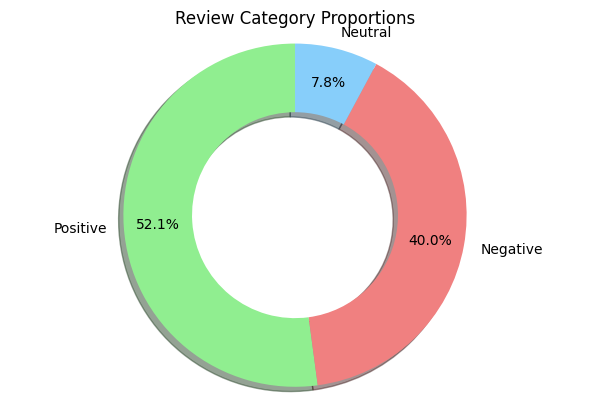

In [ ]:
# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Review Category Proportions')

plt.show()

# 3. PreProcessing

## Preprocessing Tahap 1

In [ ]:
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(text):
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long
      text = text.replace(char,character[i])
      charac_long -= 1
  return text

In [ ]:
import re

def preprocess_v1(df):
    df['clean_review'] = df['review'].apply(clean_review)
    return df

def clean_review(text):
    if isinstance(text, str):  # Memeriksa apakah objek text adalah string
        # ubah text menjadi huruf kecil
        text = text.lower()
    return text

In [ ]:
def preprocess_v1(df):
  df_pp = df.copy()
  df_pp.review_text = df_pp.review_text.map(clean_review)

  # delete empty row
  df_pp.review_text.replace('', np.nan, inplace=True)
  df_pp.review_text.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['review_text'], inplace=True)
  return df_pp

In [ ]:
df_v1 = preprocess_v1(df)

In [ ]:
# export to tsv
df_v1.to_csv('df_v1.tsv', sep='\t', header=None, index=False)

In [ ]:
df_path = 'df_v1.tsv'

#Import data
df = pd.read_csv(df_path, sep='\t', names=['review_text', 'category'])

df.head(10)

,review_text,category
0,usahakan ada notifikasi tentang bank dan masal...,negative
1,"dulu cukup sering pake blu, sekarang sudah gak...",negative
2,g ada fitur search nama penerima transfernya. ...,neutral
3,"aplikasi blu indonesia mudah di gunakan, nyama...",positive
4,blu˜•blu˜ˆ saya kecewa semakin kesini lama bg...,negative
5,"5 bintang, untuk transfer antar banknya oke, c...",positive
6,penggunaan blu! sejauh ini mudah karena bisa j...,positive
7,"blu˜luar biasa !!! sangat membantu, transaksi...",positive
8,skrg blu sdh gak se nyaman dulu. trf sdh kena ...,neutral
9,"sangat mengecewakan dan tidak recommended, di ...",negative


In [ ]:
import re
import emoji

def preprocess_v1(df):
    df['clean_review'] = df['review'].apply(clean_review)
    return df

def clean_review(text):
    if isinstance(text, str):  # Memeriksa apakah objek text adalah string
        # ubah enter menjadi spasi
        text = re.sub(r'\n', ' ', text)
        # hapus emoji
        text = emoji.demojize(text)
        text = re.sub(':[A-Za-z_-]+:', ' ', text)  # hapus emoji
        # hapus emoticon
        text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)
        # hapus link
        text = re.sub(
            r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})",
            "", text)
        # hapus username
        text = re.sub(r"@[^\s]+[\s]?", ' ', text)
        # hapus hashtag
        text = re.sub(r'#(\S+)', r'\1', text)
        # hapus angka dan beberapa simbol
        text = re.sub(r'[^A-Za-z]+', ' ', text)
        # hapus karakter berulang
        text = repeatcharClean(text)
        # clear spasi
        text = re.sub('[ ]+', ' ', text)
    return text

def repeatcharClean(text):
    # Fungsi untuk menghapus karakter berulang
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1", text)

In [ ]:
def preprocess_v1(df):
  df_pp = df.copy()
  df_pp.review_text = df_pp.review_text.map(clean_review)

  # delete empty row
  df_pp.review_text.replace('', np.nan, inplace=True)
  df_pp.review_text.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['review_text'], inplace=True)
  return df_pp

In [ ]:
df_v1 = preprocess_v1(df)

In [ ]:
# export to tsv
df_v1.to_csv('df_v1.tsv', sep='\t', header=None, index=False)

In [ ]:
df_path = 'df_v1.tsv'

#Import data
df = pd.read_csv(df_path, sep='\t', names=['review_text', 'category'])

df.head(10)

,review_text,category
0,usahakan ada notifikasi tentang bank dan masal...,negative
1,dulu cukup sering pake blu sekarang sudah gak ...,negative
2,g ada fitur search nama penerima transfernya d...,neutral
3,aplikasi blu indonesia mudah di gunakan nyaman...,positive
4,blu blu saya kecewa semakin kesini lama bgt d...,negative
5,bintang untuk transfer antar banknya oke cepe...,positive
6,penggunaan blu sejauh ini mudah karena bisa ja...,positive
7,blu luar biasa sangat membantu transaksi nya l...,positive
8,skrg blu sdh gak se nyaman dulu trf sdh kena b...,neutral
9,sangat mengecewakan dan tidak recommended di s...,negative


## Preprocessing Tahap 2

In [ ]:
# additional_stopword:list kata tdk penting
additional_stop = [] #['ya', 'deh', 'dia']
# default stopword
default_stop = pd.read_csv(stopword_path, delim_whitespace=True, names=['stopwords'])
default_stop = default_stop.stopwords.to_list()
# combine all stopword
list_stopwords = []
list_stopwords = default_stop + additional_stop
# remove specific stopword
# list_stopwords.remove("sangat")
# list_stopwords.remove("sekali")

In [ ]:
word_list = pd.read_csv(word_list_path)
normalize_word_dict = {}
for index, row in word_list.iterrows():
    if row[0] not in normalize_word_dict:
        normalize_word_dict[row[0]] = row[1]

In [ ]:
def normalize_review(text):
  # tokenize
  list_text = word_tokenize(text)
  # ubah bahasa alay
  list_text = [normalize_word_dict[term] if term in normalize_word_dict else term for term in list_text]
  # stemming
  # factory = StemmerFactory()
  # stemmer = factory.create_stemmer()
  # list_text = [stemmer.stem(word) for word in list_text]
  # hapus kata yang termasuk stopword
  # list_text = [word for word in list_text if word not in list_stopwords]
  # gabung kembali kalimat
  text = " ".join(list_text)
  return text

In [ ]:
def preprocess_v2(df):
  df_pp = df.copy()
  df_pp.review_text = df_pp.review_text.map(normalize_review)

  # delete empty row
  df_pp.review_text.replace('', np.nan, inplace=True)
  df_pp.review_text.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['review_text'], inplace=True)
  return df_pp

In [ ]:
# take a while
df_v2  = preprocess_v2(df_v1)

In [ ]:
# export to tsv
df_v2.to_csv('df_v2.tsv', sep='\t', header=None, index=False)

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize

# Import data
df_path = 'df_v1.tsv'
df = pd.read_csv(df_path, sep='\t', names=['review_text', 'category'])

# Tokenize review_text column
df['tokenized_text'] = df['review_text'].apply(lambda x: word_tokenize(str(x)))

# Display first 10 rows
df.head(10)

,review_text,category,tokenized_text
0,usahakan ada notifikasi tentang bank dan masal...,negative,"[usahakan, ada, notifikasi, tentang, bank, dan..."
1,dulu cukup sering pake blu sekarang sudah gak ...,negative,"[dulu, cukup, sering, pake, blu, sekarang, sud..."
2,g ada fitur search nama penerima transfernya d...,neutral,"[g, ada, fitur, search, nama, penerima, transf..."
3,aplikasi blu indonesia mudah di gunakan nyaman...,positive,"[aplikasi, blu, indonesia, mudah, di, gunakan,..."
4,blu blu saya kecewa semakin kesini lama bgt d...,negative,"[blu, blu, saya, kecewa, semakin, kesini, lama..."
5,bintang untuk transfer antar banknya oke cepe...,positive,"[bintang, untuk, transfer, antar, banknya, oke..."
6,penggunaan blu sejauh ini mudah karena bisa ja...,positive,"[penggunaan, blu, sejauh, ini, mudah, karena, ..."
7,blu luar biasa sangat membantu transaksi nya l...,positive,"[blu, luar, biasa, sangat, membantu, transaksi..."
8,skrg blu sdh gak se nyaman dulu trf sdh kena b...,neutral,"[skrg, blu, sdh, gak, se, nyaman, dulu, trf, s..."
9,sangat mengecewakan dan tidak recommended di s...,negative,"[sangat, mengecewakan, dan, tidak, recommended..."


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to save the file in Google Drive
output_path = '/content/drive/MyDrive/Skripsi/blu/df_tokenized.tsv'

# Save DataFrame as tsv
df.to_csv(output_path, sep='\t', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_path = '/content/drive/MyDrive/Skripsi/blu/df_tokenized.tsv'

# Import data
df = pd.read_csv(df_path, sep='\t', names=['review_text', 'category'])

df.head(10)

,review_text,category
review_text,category,tokenized_text
usahakan ada notifikasi tentang bank dan masalah gangguan jadi kita selaku pengguna tau bank mana saja yang sedang gangguan biar tidak terganggu juga aplikasi blunya apalagi transaksi sudah berhasil setelah tranfer riwayat hilang mohon perbaiki layanannya min,negative,"['usahakan', 'ada', 'notifikasi', 'tentang', '..."
dulu cukup sering pake blu sekarang sudah gak pake lagi sering gangguan terutama pengiriman lewat bca dan bsi sering gangguan seharus nya dgn ada nya biaya admin bisa lebih meningkatkan pelayanan ini malah tambah jeblok,negative,"['dulu', 'cukup', 'sering', 'pake', 'blu', 'se..."
g ada fitur search nama penerima transfernya dan blum sepenuhnya gratis seperti sebelah,neutral,"['g', 'ada', 'fitur', 'search', 'nama', 'pener..."
aplikasi blu indonesia mudah di gunakan nyaman dan aman awalnya fiturnya banyak dan lengkap tapi sekarang berkurang dan hari ini kenapa tidak bisa melakukan transaksi,positive,"['aplikasi', 'blu', 'indonesia', 'mudah', 'di'..."
blu blu saya kecewa semakin kesini lama bgt dan banyak gangguan saya mengusulkan tolong ada tombol batal transaksi jangan ke email dulu jadi agak ribet dan menyulitkan prosesnya masalahnya uang trf nya ga sedikit penanganan protes juga lama,negative,"['blu', 'blu', 'saya', 'kecewa', 'semakin', 'k..."
bintang untuk transfer antar banknya oke cepet ga kalah sama app sebelah hanya yg perlu diperbaiki untuk verifikasi foto kameranya hasilnya kurang fokus seperti dizoom tingkatkan trs layanannya mantap blu blu blu blu blu blu,positive,"['bintang', 'untuk', 'transfer', 'antar', 'ban..."
penggunaan blu sejauh ini mudah karena bisa jadi perantara antar bank dan ewallet biaya adminnya juga rendah tidak seperti klo kita transfer manual antar bank bagus banget aplikasinya solutif banget buat kita yg punya banyak rekening acc ewallet,positive,"['penggunaan', 'blu', 'sejauh', 'ini', 'mudah'..."
blu luar biasa sangat membantu transaksi nya lebih cepat via virtual account dan untuk via transfer bank tidak kalah cepat juga sih antara menit biaya transaksi nya juga luar biasa murah pisan sekedar saran untuk bukti transaksinya lebih baik lagi resolusi nya soalnya kalo menggunakan printer bluetooth hasilnya kurang memuaskan terima kasih sukses terus blu indonesia,positive,"['blu', 'luar', 'biasa', 'sangat', 'membantu',..."
skrg blu sdh gak se nyaman dulu trf sdh kena biaya sering gangguan juga mohon di perbaiki,neutral,"['skrg', 'blu', 'sdh', 'gak', 'se', 'nyaman', ..."


In [ ]:
df_path = 'df_v2.tsv'

# Import data
df = pd.read_csv(df_path, sep='\t', names=['review_text', 'category'])

df.head(10)

,review_text,category
0,usahakan ada notifikasi tentang bank dan masal...,negative
1,dulu cukup sering pakai blu sekarang sudah eng...,negative
2,enggak ada fitur search nama penerima transfer...,neutral
3,aplikasi blu indonesia mudah di gunakan nyaman...,positive
4,blu blu saya kecewa semakin kesini lama banget...,negative
5,bintang untuk transfer antar banknya oke cepat...,positive
6,penggunaan blu sejauh ini mudah karena bisa ja...,positive
7,blu luar biasa sangat membantu transaksi nya l...,positive
8,sekarang blu sudah enggak se nyaman dulu trans...,neutral
9,sangat mengecewakan dan tidak recommended di s...,negative


In [ ]:
def make_corpus(column):

    corpus_list = []

    for text in column:
        cleaned_list = text.split(' ')
        corpus_list.extend(cleaned_list)

    # transform list of words into 1 body of text
    corpus = ' '.join(corpus_list)
    corpus = re.sub('[ ]+',' ',corpus) # replace double whitespace with one

    return corpus

In [ ]:
# Takes a while
corpus = make_corpus(df_v2.review_text)

In [ ]:
# counting unique words
corpus_set = set(corpus.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 14694


In [ ]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples

    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})

    return df

In [ ]:
corpus_freq = word_freq(corpus, top=20)

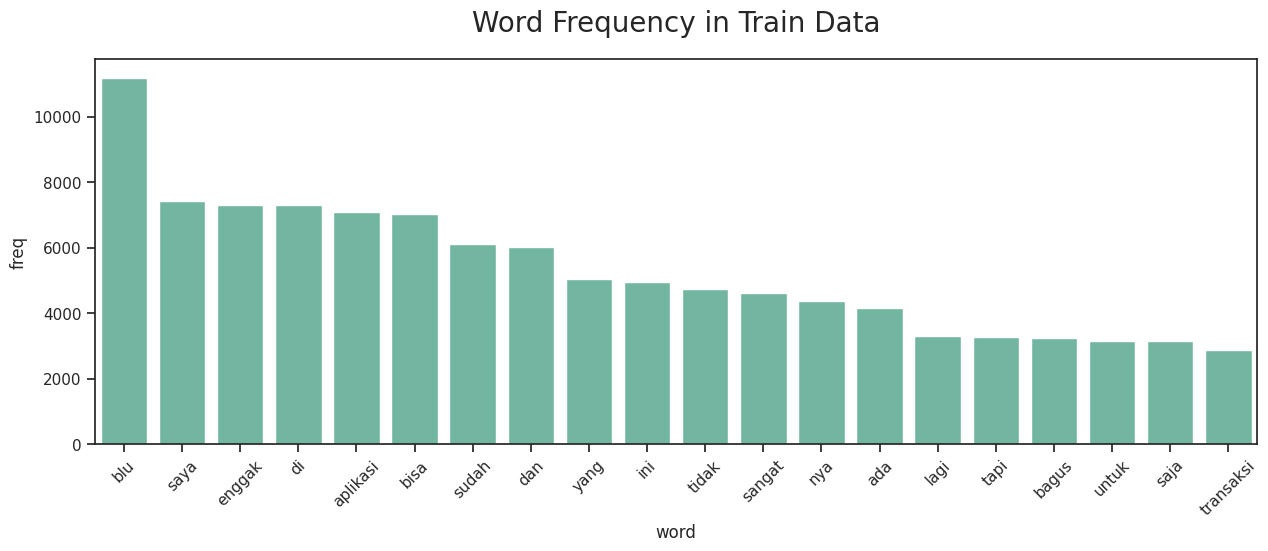

In [ ]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

# sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax2)
# ax2.set_title('Word Frequency in Train Data')
# ax2.tick_params(axis='x', rotation=45)

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

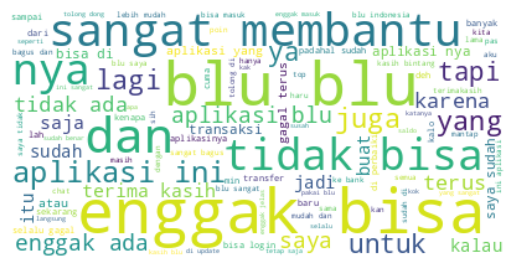

In [ ]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 4. Splitting

In [ ]:
# train val split
train_set, val_set = train_test_split(df_v2, test_size=0.3, stratify=df_v2.category, random_state=1)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.category, random_state=1)

In [ ]:
print(f'Train shape: {train_set.shape}')
print(f'Val shape: {val_set.shape}')
print(f'Test shape: {test_set.shape}')

Train shape: (17448, 2)
Val shape: (5010, 2)
Test shape: (2468, 2)


In [ ]:
# export to tsv
train_set.to_csv('/content/drive/MyDrive/Skripsi/blu/train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('/content/drive/MyDrive/Skripsi/blu/val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('/content/drive/MyDrive/Skripsi/blu/test_set.tsv', sep='\t', header=None, index=False)

# 5. Modeling

## a. Finetuning IndoBERT

In [ ]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [ ]:
# Set random seed
set_seed(27)

## b. Load Model

In [ ]:
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification

# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

# Train the model on your downstream task dataset
# Perform predictions or inference with the trained model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Struktur model
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
count_param(model)

124443651

## c. Prepare Dataset

In [ ]:
train_dataset_path = '/content/drive/MyDrive/Skripsi/blu/train_set.tsv'
valid_dataset_path = '/content/drive/MyDrive/Skripsi/blu/val_set.tsv'
test_dataset_path = '/content/drive/MyDrive/Skripsi/blu/test_set.tsv'

In [ ]:
# fungsi dataset loader dari utils IndoNLU
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i) #word to index
print(i2w) #index to word

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


## d. Uji coba pre-trained model

In [ ]:
text = 'tidak bisa transfer antar bank'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: tidak bisa transfer antar bank | Label : neutral (55.560%)


In [ ]:
text = 'bisa transfer antar bank?'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bisa transfer antar bank? | Label : neutral (49.986%)


In [ ]:
text = 'bisa transfer antar bank'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bisa transfer antar bank | Label : neutral (48.186%)


## e. Fine Tuning & Prediksi Evaluation

In [ ]:
# Tentukan optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

### Training

In [ ]:
# Train
n_epochs = 5
history = defaultdict(list)
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Hitung skor train metrics
        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # save train acc for learning curve
    history['train_acc'].append(metrics['ACC'])

    # Evaluate di validation set
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Hitung total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Hitung skor evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

    # save validation acc for learning curve
    history['val_acc'].append(metrics['ACC'])

  0%|          | 0/546 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 1) TRAIN LOSS:0.5209 LR:0.00000300: 100%|██████████| 546/546 [03:17<00:00,  3.49it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multith

(Epoch 1) TRAIN LOSS:0.5209 ACC:0.81 F1:0.58 REC:0.59 PRE:0.62 LR:0.00000300


  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

(Epoch 1) VALID LOSS:0.4590 ACC:0.83 F1:0.59 REC:0.61 PRE:0.74


  0%|          | 0/546 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 2) TRAIN LOSS:0.4252 LR:0.00000300: 100%|██████████| 546/546 [03:23<00:00,  3.63it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multith

(Epoch 2) TRAIN LOSS:0.4252 ACC:0.84 F1:0.63 REC:0.63 PRE:0.74 LR:0.00000300


  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

(Epoch 2) VALID LOSS:0.4502 ACC:0.84 F1:0.62 REC:0.62 PRE:0.73


  0%|          | 0/546 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 3) TRAIN LOSS:0.3931 LR:0.00000300: 100%|██████████| 546/546 [03:23<00:00,  2.68it/s]


(Epoch 3) TRAIN LOSS:0.3931 ACC:0.86 F1:0.66 REC:0.66 PRE:0.76 LR:0.00000300


  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

(Epoch 3) VALID LOSS:0.4510 ACC:0.84 F1:0.62 REC:0.62 PRE:0.71


  0%|          | 0/546 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 4) TRAIN LOSS:0.3650 LR:0.00000300: 100%|██████████| 546/546 [03:24<00:00,  2.67it/s]


(Epoch 4) TRAIN LOSS:0.3650 ACC:0.87 F1:0.68 REC:0.67 PRE:0.78 LR:0.00000300


  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

(Epoch 4) VALID LOSS:0.4635 ACC:0.83 F1:0.64 REC:0.63 PRE:0.72


  0%|          | 0/546 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 5) TRAIN LOSS:0.3346 LR:0.00000300: 100%|█████████▉| 545/546 [03:22<00:00,  2.72it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multith

(Epoch 5) TRAIN LOSS:0.3346 ACC:0.88 F1:0.71 REC:0.70 PRE:0.78 LR:0.00000300


  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

(Epoch 5) VALID LOSS:0.4767 ACC:0.83 F1:0.63 REC:0.63 PRE:0.70


### Learning Curve

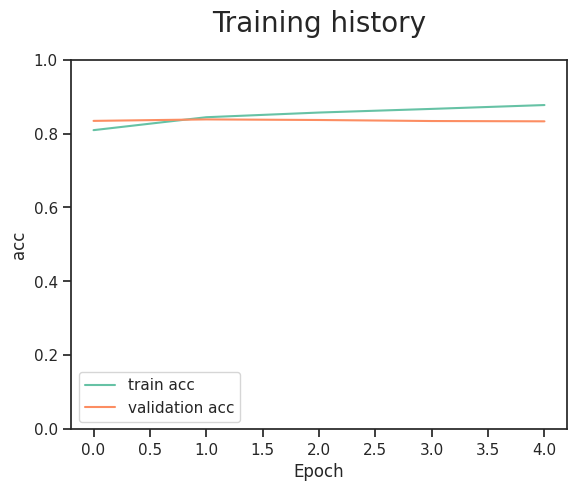

In [ ]:
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# Simpan Hasil Prediksi Validation Set
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['review_text', 'category'])
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('val result.csv', index=False)

## f. Prediksi Test Set

In [ ]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

  0%|          | 0/78 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 99%|█████████▊| 77/78 [00:11<00:00,  8.07it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock

In [ ]:
# Simpan prediksi test set
test_df = pd.read_csv(test_dataset_path, sep='\t', names=['review_text', 'category'])
test_df['pred'] = pred
test_df.head()
test_df.to_csv('test result.csv', index=False)

## e. Test fine-tuned model on sample sentences

In [ ]:
text = 'tidak bisa transfer antar bank'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: tidak bisa transfer antar bank | Label : positive (45.925%)


In [ ]:
text = 'bisa transfer antar bank'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bisa transfer antar bank | Label : positive (98.413%)


In [ ]:
text = 'bisa transfer antar bank?'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bisa transfer antar bank? | Label : positive (98.187%)


# 6. Evaluasi

In [ ]:
val_real = val_df.category
val_pred = val_df.pred

test_real = test_df.category
test_pred = test_df.pred

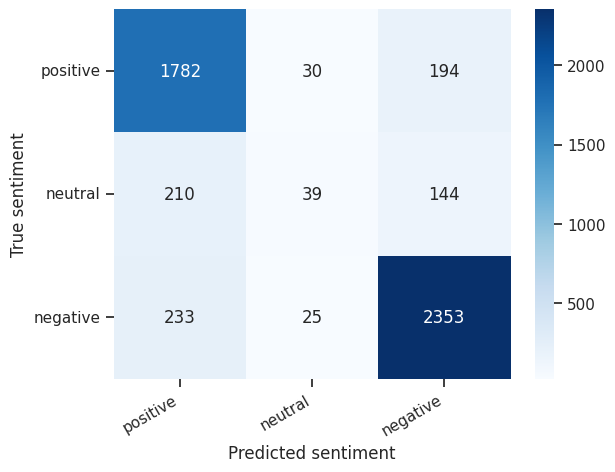

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(val_real, val_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(val_real, val_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.80      0.89      0.84      2006
     neutral       0.41      0.10      0.16       393
    negative       0.87      0.90      0.89      2611

    accuracy                           0.83      5010
   macro avg       0.70      0.63      0.63      5010
weighted avg       0.81      0.83      0.81      5010



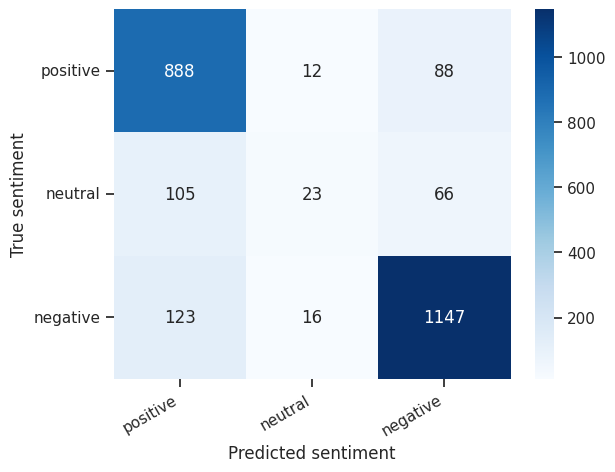

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(test_real, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(test_real, test_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.80      0.90      0.84       988
     neutral       0.45      0.12      0.19       194
    negative       0.88      0.89      0.89      1286

    accuracy                           0.83      2468
   macro avg       0.71      0.64      0.64      2468
weighted avg       0.81      0.83      0.81      2468



In [ ]:
import torch
from transformers import BertModel, BertConfig

# Inisialisasi arsitektur BERT
model_name = 'bert-base-uncased'
config = BertConfig.from_pretrained(model_name)
model = BertModel(config)

# Simpan model PyTorch
torch.save(model.state_dict(), "bert_model.pth")

print("Model BERT telah disimpan dalam format PyTorch.")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Model BERT telah disimpan dalam format PyTorch.
